# Jupyter Notebook for LED Planck's Constant

# Imports and Data Loading

In [1343]:
# imports 
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [1344]:
# constants
# all in nm
RESISTANCE_LED_6 = 660
RESISTANCE_LED_6 = 860
RESISTANCE_LED_7 = 940
UNCERTAINTY_LED = 10

ROOM_TEMPERATURE = 293 # Kelvin
ROOM_TEMP_VT = 0.026
ELEMENTARY_CHARGE = 1.60217663 * 10 ** -19 # Coulombs

In [1345]:
# csv data for LEDs 1 to 5

led15_data =  np.loadtxt("../data/LED1to5.csv", delimiter=',', comments='#', unpack=True, skiprows=1) # retrieve from csv.

led15_wavelength = led15_data[0]
led15_voltage = led15_data[1]
led15_current = led15_data[2]
led15_wavelength_error = led15_data[3]
led15_voltage_error = led15_data[4]
led15_current_error = led15_data[5]

In [1346]:
# csv data for LED 5, 6, 7

led5_data =  np.loadtxt("../data/LED5.csv", delimiter=',', comments='#', unpack=True, skiprows=1) # retrieve from csv.
led6_data =  np.loadtxt("../data/LED5.csv", delimiter=',', comments='#', unpack=True, skiprows=1)
led7_data =  np.loadtxt("../data/LED5.csv", delimiter=',', comments='#', unpack=True, skiprows=1)

# LED 5
led5_voltage = led5_data[0]
led5_current = led5_data[1] * 10 ** -6
led5_voltage_error = led5_data[2]
led5_current_error = led5_data[3] * 10 ** -6

# LED 6
led6_voltage = led6_data[0]
led6_current = led6_data[1] * 10 ** -6
led6_voltage_error = led6_data[2]
led6_current_error = led6_data[3] * 10 ** -6

# LED 7
led7_voltage = led7_data[0]
led7_current = led7_data[1] * 10 ** -6
led7_voltage_error = led7_data[2]
led7_current_error = led7_data[3] * 10 ** -6


# Model Functions

$$h = \frac{qV}{f}$$

This is just used for calculations, not curve fitting.

In [1347]:
def planck(V, f, q):
    return (q * V) / f

$$I =  I_s \left(e^\frac{V}{\eta V_T} - 1\right)$$

We care about $V$ in this equation.
Assume $\eta$ and $I_s$ are the same for all LEDs.

In [1348]:
def shockley(V, I_s, eta): # for modelling
    return I_s * (np.exp(V / (eta) ) - 1)

Equation for Chi Squared Reduced:\
$\chi^2_r$ is calculated with this formula:
$$\chi^{2}_{r} = \frac{1}{v}\sum_{i=1}^{N} \left(\frac{y_i - f(x_i)}{u(x_i)}\right)^2$$

In [1349]:
# function for calculating chi squared reduced.
def chi_squared_reduced(y_measure, y_predict, errors, number_of_parameters):
    """Calculates the reduced chi squared of data, prediction and errors."""
    return (np.sum(((y_measure - y_predict) ** 2 )/ (errors ** 2)))/(y_measure.size - number_of_parameters)


# Curve Fit and Model Parameters

- Fit data using 5 to get η and I_s.
- Assume these are the same for 6 and 7
- Use shockley to find V value from obtained parameters
    - Fit for V,
- Use V in hf = qV
- solve for h.

In [1350]:
# curve fit of shockley using curve_fit
popt, pcov = curve_fit(shockley, xdata=led5_voltage, ydata=led5_current, absolute_sigma=True, sigma = led5_current_error)
pstd = np.sqrt(np.diag(pcov))
pstd

array([1.57977651e-12, 9.16920555e-05])

In [1351]:
print("chi squared reduced =",chi_squared_reduced(led5_current, shockley(led5_voltage, popt[0], popt[1]), led5_current_error, len(popt)))
print(f"Values of: \nI_s: {popt[0]}, \neta: {popt[1]/ROOM_TEMP_VT}")
pvar = np.diag(pcov)
print(f"Uncertainty in: \nI_s: {np.sqrt(pvar[0])}, \neta: {pvar[1]/ROOM_TEMP_VT}")

chi squared reduced = 7485.384653785552
Values of: 
I_s: 1.7064323387888412e-10, 
eta: 5.16367946356979
Uncertainty in: 
I_s: 1.5797765115210343e-12, 
eta: 3.2336280954372456e-07


# Graphs for Curve Fit

In [1352]:
def plot_graph(xdata, ydata, xerr, yerr, fun, xlab, ylab, title, model_name):
    plt.errorbar(x = xdata, y = ydata, xerr=xerr, yerr=yerr, fmt= 'o',
                ms=2, color='teal', ecolor='aquamarine', label=ylab)

    plt.plot(xdata, fun(xdata, popt[0], popt[1]), label = model_name, color='red')

    # Legend and titles
    plt.legend()
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)

    plt.show()

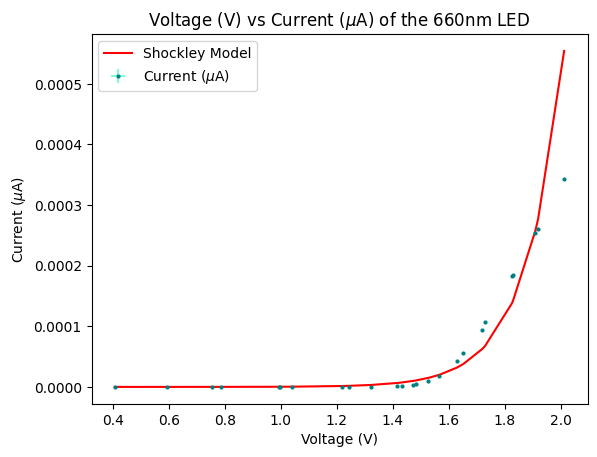

In [1353]:
plot_graph(led5_voltage, led5_current, led5_voltage_error, led5_current_error, shockley,
            'Voltage (V)', 'Current ($\mu$A)', 'Voltage (V) vs Current ($\mu$A) of the 660nm LED', 'Shockley Model')

# Graphs for Residuals

In [1354]:
def plot_residuals(xdata, ydata, xerr, yerr, fun, xlab, ylab, title, scatter_label, horiz_label):
    # residuals
    residuals = ydata - fun(xdata, popt[0], popt[1])


    plt.errorbar(x = xdata, y = residuals, yerr = yerr, fmt= 'o', ms=4, label=scatter_label,ls='', color='teal', ecolor='aquamarine')
    plt.axhline(y=0, color='orange', linestyle='--', linewidth=1, label=horiz_label) 

    # legend and titles
    plt.legend()
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)
    plt.legend(fontsize=7)
    plt.show()

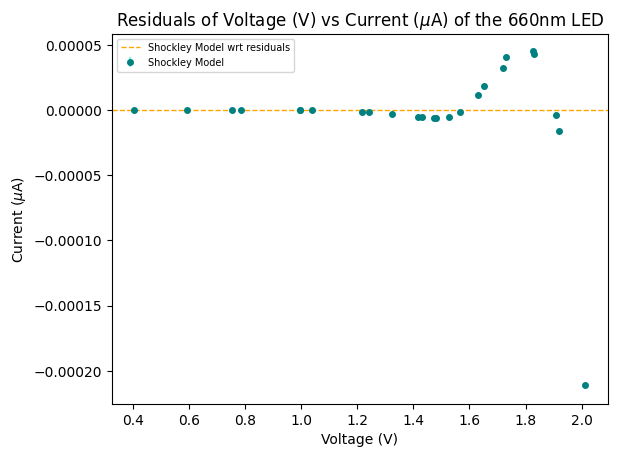

In [1355]:
plot_residuals(led5_voltage, led5_current, led5_voltage_error, led5_current_error, shockley,
            'Voltage (V)', 'Current ($\mu$A)', 'Residuals of Voltage (V) vs Current ($\mu$A) of the 660nm LED', 'Shockley Model', 'Shockley Model wrt residuals')

# Results

In [1356]:
def product_propagation(x, y, ux, uy):
    return (((ux / x) ** 2 + (uy / y) ** 2) ** 0.5)

def f_from_w(w):
    return (3 * 10 ** 8) / w

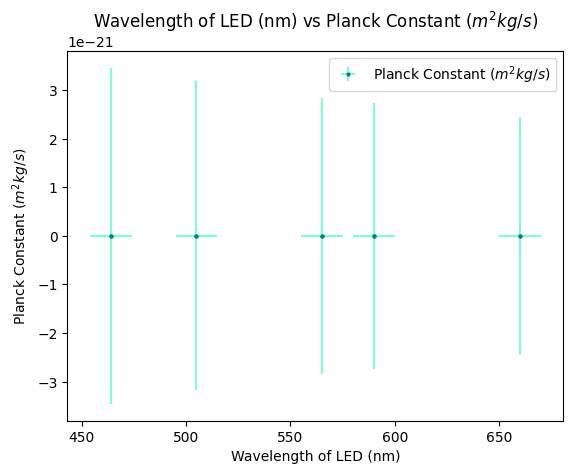

In [1357]:
plt.errorbar(x = led15_wavelength, y = planck(led15_voltage, f_from_w(led15_wavelength* 10 ** -9), ELEMENTARY_CHARGE), 
             xerr=led15_wavelength_error,
             yerr= ELEMENTARY_CHARGE * product_propagation(led15_wavelength, led15_voltage, led15_wavelength_error, led15_voltage_error), fmt= 'o',
               
               ms=2, color='teal', ecolor='aquamarine', label='Planck Constant ($m^2 kg / s$)')

plt.legend()
plt.xlabel('Wavelength of LED (nm)')
plt.ylabel('Planck Constant ($m^2 kg / s$)')
plt.title('Wavelength of LED (nm) vs Planck Constant ($m^2 kg / s$)')

plt.show()

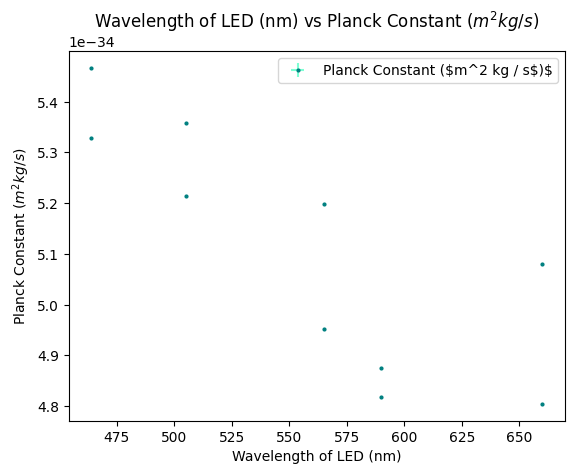

In [1358]:
plt.errorbar(x = led15_wavelength, y = planck(led15_voltage, f_from_w(led15_wavelength* 10 ** -9), ELEMENTARY_CHARGE), 
             xerr=led15_wavelength_error / 10 ** 30,
             yerr= ELEMENTARY_CHARGE * product_propagation(led15_wavelength, led15_voltage, led15_wavelength_error, led15_voltage_error) / 10 ** 30, fmt= 'o',
               
               ms=2, color='teal', ecolor='aquamarine', label='Planck Constant ($m^2 kg / s$)$')

plt.legend()
plt.xlabel('Wavelength of LED (nm)')
plt.ylabel('Planck Constant ($m^2 kg / s$)')
plt.title('Wavelength of LED (nm) vs Planck Constant ($m^2 kg / s$)')

plt.show()

# Results for LEDs 6 & 7

To find the current and threshold voltage of the LEDs, the data is found by taking the mean of the currents, and curve fitting the other threshold voltages.

In [1359]:
# from the equation hf = qV, the voltage is proportional to wavelength, which is inversely proportional to frequency.
# V is proportional to 1/f
def inverse_prop(wavelength, c):
    # find constant of inverse proportionality
    return c / wavelength

In [1360]:
poptw, pcovw = curve_fit(inverse_prop, xdata=led15_wavelength, ydata=led15_voltage, absolute_sigma=True, sigma = led15_voltage_error)
pstdw = np.sqrt(np.diag(pcovw))
pstdw

array([0.49925647])

In [1361]:
print("chi squared reduced =",chi_squared_reduced(led15_voltage, inverse_prop(led15_wavelength, poptw[0]), led15_voltage_error, len(poptw)))
print(f"Values of: \nc: {popt[0]}")
pvar = np.diag(pcov)
print(f"Uncertainty in: \c: {np.sqrt(pvar[0])}")

chi squared reduced = 817.3465861957728
Values of: 
c: 1.7064323387888412e-10
Uncertainty in: \c: 1.5797765115210343e-12


Predicted Values

In [1362]:
print(f"860nm: {inverse_prop(860, poptw[0])}V")
print(f"940nm: {inverse_prop(940, poptw[0])}V")
print(f"Current: {np.mean(led15_current)}")

860nm: 1.1180492808638711V
940nm: 1.0228961505775842V
Current: 1.1308


In [1363]:
# LED 6 and 7
# planck values
print(planck(inverse_prop(860, poptw[0]), f_from_w(860 * 10 ** -9), ELEMENTARY_CHARGE)) # 6
print(planck(inverse_prop(940, poptw[0]), f_from_w(940 * 10 ** -9), ELEMENTARY_CHARGE)) # 7

5.135095629766748e-34
5.135095629766748e-34


# Appendix

Error bars are included in all graphs; they are sometimes too small to be visible.